In [2]:
from rosbags.rosbag2 import Reader
from rclpy.serialization import deserialize_message
from beep_interfaces.msg import MotorData
from sensor_msgs.msg import Imu

from pathlib import Path
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.ndimage import gaussian_filter1d

from traction_testing import WHEEL_RADIUS, dt, linear_velocity_profile 

Text(0, 0.5, 'Velocity (m/s)')

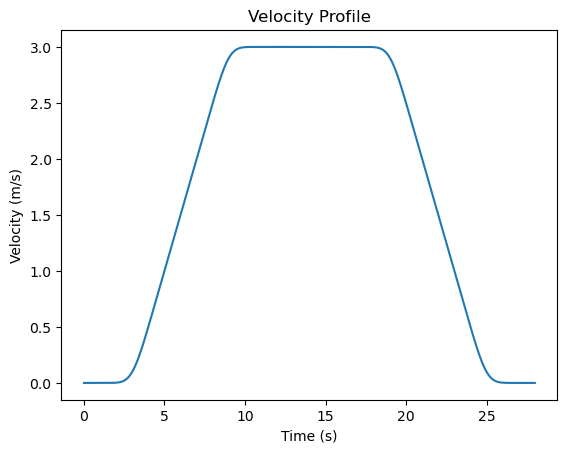

In [3]:
t = np.linspace(0, len(linear_velocity_profile) * dt, len(linear_velocity_profile))

plt.figure()
plt.plot(t, linear_velocity_profile)

plt.title("Velocity Profile")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")


In [4]:
class TopicMeta:
    def __init__ (self, name, type):
        self.name = name
        self.type = type

topic_metas = {
    "/dev0/motor_data": TopicMeta("motor0", MotorData),
    "/dev1/motor_data": TopicMeta("motor1", MotorData),
    "/imu0/data": TopicMeta("imu", Imu)
}

def get_all_data(path):
    data = {}
    timestamps = {}
    
    #read from rosbags
    with Reader(path) as reader:
        for connection in reader.connections:
            if connection.topic in topic_metas.keys():
                print(connection.topic, connection.msgtype)
                name = topic_metas[connection.topic].name
                data[name] = []
                timestamps[name] = []

        for connection, timestamp, rawdata in reader.messages():
            if connection.topic in topic_metas:
                meta = topic_metas[connection.topic]
                msg = deserialize_message(rawdata, meta.type)
                data[meta.name].append(msg)
                timestamps[meta.name].append(timestamp)

    #turn timestamps to time
    time = timestamps
    for key, val in timestamps.items():
        time[key] = np.array(val)
        
    return data, time

def reduce_object_vector (vector, attribute):
    return np.array(list(map(lambda x: getattr(x, attribute), vector)))
    
def get_graphable_data(data, time, source, attribute="data", getTimestamps = False):
    r_time = time[source]
    if (getTimestamps==False):
        r_time = (time[source] - time[source][0]) / 1e9
        
    return reduce_object_vector(data[source], attribute), r_time

def synch_timestamps (timestamps):
    earliest = min(list(map(lambda x: x[0], timestamps)))
    times = list(map(lambda x: (x - earliest) / 1e9, timestamps))
    return times


In [5]:
bags = glob("../bags/*")
bags.sort()
path = Path(bags[-1])
data, time = get_all_data(path)

/imu0/data sensor_msgs/msg/Imu


[-0.00390625 -0.00390625  0.03515625 ...  0.00390625 -0.03515625
  0.00390625]


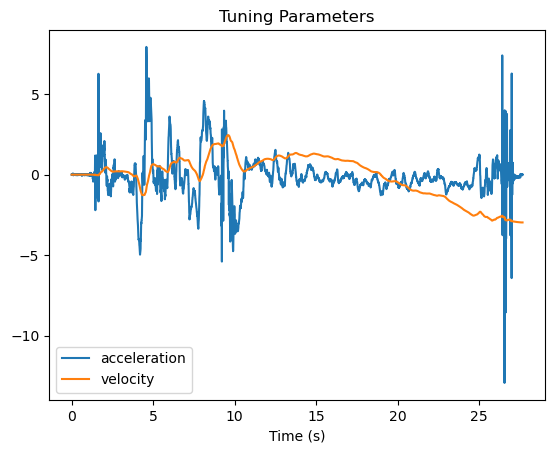

In [6]:
linear_acceleration, linear_acceleration_t = get_graphable_data(data, time, "imu", "linear_acceleration", getTimestamps=False)

linear_acceleration_x = reduce_object_vector(linear_acceleration, "x")
print(linear_acceleration_x)
linear_velocity_x = integrate.cumulative_trapezoid(linear_acceleration_x, x = linear_acceleration_t)
linear_velocity_x = np.append(linear_velocity_x, linear_velocity_x[-1])

fig2, ax2 = plt.subplots()
ax2.plot(linear_acceleration_t, linear_acceleration_x)
ax2.plot(linear_acceleration_t, linear_velocity_x)
ax2.set_xlabel("Time (s)")
ax2.set_title("Tuning Parameters")
ax2.legend(["acceleration", "velocity"])

In [7]:

motor_angular_velocity,  motor_angular_velocity_t = get_graphable_data(data, time, "motor0", "velocity", getTimestamps=True)

#print(linear_acceleration_t.shape,  motor_angular_velocity_t.shape)

#linear_acceleration = np.array([100, 200, 300, 400])
#motor_angular_velocity = np.array([1000, 2000, 3000, 4000])

#linear_acceleration_t = np.array([1, 3, 5, 7])
#motor_angular_velocity_t = np.array([2, 4, 6, 8])

linear_acceleration_x = reduce_object_vector(linear_acceleration, "x")
linear_velocity_x = integrate.cumulative_trapezoid(linear_acceleration_x, x = linear_acceleration_t)
linear_velocity_x = np.append(linear_velocity_x, linear_velocity_x[-1])

interpolated_t = np.sort(np.concatenate((linear_acceleration_t,  motor_angular_velocity_t)))

linear_acceleration_interpolated = np.empty(interpolated_t.shape)
linear_velocity_x_interpolated = np.empty(interpolated_t.shape)
motor_angular_velocity_interpolated = np.empty(interpolated_t.shape)

linear_acceleration_interpolated[0] =  linear_acceleration_x[0]
linear_velocity_x_interpolated[0] = linear_velocity_x[0]
motor_angular_velocity_interpolated[0] =  motor_angular_velocity[0]


for i in range(1, interpolated_t.shape[0]):
    t = interpolated_t[i]
    if (t in linear_acceleration_t):
        index = np.where(linear_acceleration_t == t)
        linear_acceleration_interpolated[i] = linear_acceleration_x[index]
    else:
        linear_acceleration_interpolated[i] = linear_acceleration_interpolated[i-1]

    if (t in linear_acceleration_t):
        index = np.where(linear_acceleration_t == t)
        linear_velocity_x_interpolated[i] = linear_velocity_x[index]
    else:
        linear_velocity_x_interpolated[i] = linear_velocity_x_interpolated[i-1]

    if (t in motor_angular_velocity_t):
        index = np.where(motor_angular_velocity_t == t)
        motor_angular_velocity_interpolated[i] = motor_angular_velocity[index]
    else:
        motor_angular_velocity_interpolated[i] = motor_angular_velocity_interpolated[i-1]


epsilon = 1e-9
slip = (motor_angular_velocity_interpolated * WHEEL_RADIUS) / (linear_velocity_x_interpolated + epsilon)
print(linear_acceleration_interpolated)
print(linear_velocity_x_interpolated)
print(motor_angular_velocity_interpolated)


KeyError: 'motor0'